# Revised Universal Soil Loss Equation Notebook

## Introduction

Soil erosion poses a growing threat to global food security, with up to 40% of the world’s topsoil already degraded — a figure projected to rise to 90% by 2050 (UNCCD, 2022). As population growth intensifies land pressure, the ability to model and manage soil loss becomes critical. The Revised Universal Soil Loss Equation (RUSLE) is a widely adopted empirical model for estimating average annual soil erosion caused by rainfall and surface runoff.

This notebook implements a GIS-based RUSLE workflow in Python using open-source libraries. Each factor in the RUSLE equation is calculated separately and transparently:

```
A = R × K × LS × C × P
```

Where:
- *A* = annual soil loss (tonnes/hectare/year)
- *R* = rainfall erosivity
- *K* = soil erodibility
- *LS* = slope length and steepness
- *C* = cover management
- *P* = support practices



## How to Choose and Apply a Custom CRS

At the beginning of this notebook, you’ll find a code cell that allows you to select a Coordinate Reference System (CRS) appropriate for your study area. By setting the `SELECTED_CRS_KEY` in that cell, all subsequent data loading, reprojection, and analysis steps will automatically adapt to your chosen CRS. This ensures that all rasters and vector layers align properly, no matter which country or region you’re working in.

1. **Locate the “AVAILABLE CRS OPTIONS” dictionary.**  
   You will see a dict named `CRS_OPTIONS` listing common projections by name (e.g., “Irish National Grid”) and their EPSG code (e.g., `EPSG:29903`).

2. **Edit the `SELECTED_CRS_KEY` value.**  
   - Find the line that reads:  
     ```python
     SELECTED_CRS_KEY = "Irish National Grid"
     ```  
   - Replace the text inside the quotes with one of the keys from `CRS_OPTIONS`. For example, to use global latitude/longitude, change it to:  
     ```python
     SELECTED_CRS_KEY = "WGS84 (Global Latitude/Longitude)"
     ```  
   - Do not include extra quotation marks or typos; the key must exactly match one of the keys in `CRS_OPTIONS`.

In [1]:
import pyproj

# ------------------------------------------------------------------------------
# AVAILABLE CRS OPTIONS: pick one key below and set it to `SELECTED_CRS_KEY`
# ------------------------------------------------------------------------------

CRS_OPTIONS = {
    "WGS84 (Global Latitude/Longitude)": "EPSG:4326",
    "Irish National Grid":                     "EPSG:29903",
    "British National Grid":                   "EPSG:27700",
    "ETRS89 / LAEA Europe":                    "EPSG:3035",
    "Web Mercator":                            "EPSG:3857"
}

# ─────────────────────────────────────────────────────────────────────────────
# 1) Choose exactly one key from CRS_OPTIONS and assign here:
SELECTED_CRS_KEY = "Irish National Grid"
#    └─ For example, to work in Irish National Grid instead, use:
#       SELECTED_CRS_KEY = "Irish National Grid"
# ─────────────────────────────────────────────────────────────────────────────

TARGET_CRS = pyproj.CRS(CRS_OPTIONS[SELECTED_CRS_KEY])


# Calculating R-Factor

The initial data for R comes from the Centre for Environmental Data Analysis (CEDA) at https://data.ceda.ac.uk/badc/ukmo-hadobs/data/insitu/MOHC/HadOBS/HadUK-Grid/v1.3.0.ceda/1km. In this example 2021 data was used but you can update this with your own raster. The raster must contain annual rainfall averages in mm to be compatible with this code. 


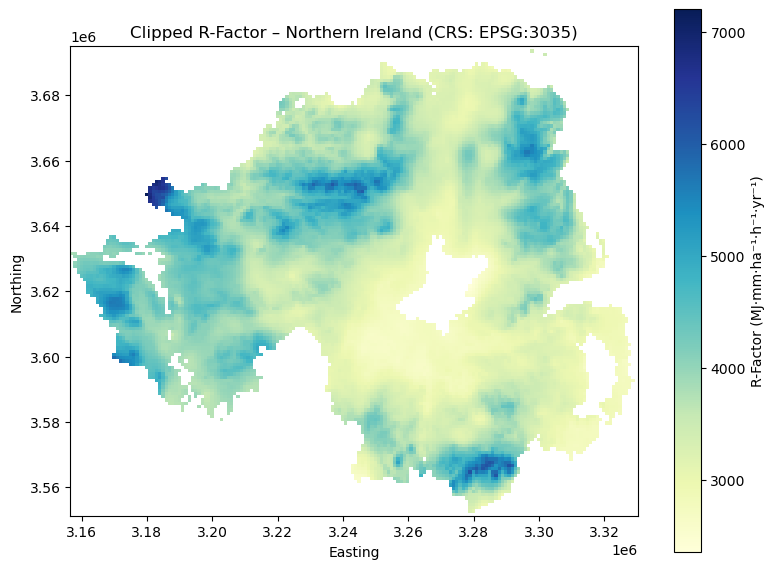

In [2]:
import xarray as xr
import rioxarray  # for setting CRS and reprojecting
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterio.warp import calculate_default_transform, reproject, Resampling
import numpy as np
import matplotlib.pyplot as plt
import os
import pyproj

# ------------------------------------------------------------------------------
# 0. DEFINE TARGET CRS (change the EPSG code to your chosen one)
# ------------------------------------------------------------------------------
# Possible values: "EPSG:4326", "EPSG:29903", "EPSG:27700", "EPSG:3035", "EPSG:3857", etc.
TARGET_CRS = pyproj.CRS("EPSG:3035")

# ------------------------------------------------------------------------------
# 1. Paths and setup (do not change; they point to your local files)
# ------------------------------------------------------------------------------

nc_path = r"C:\GIS_Course\EGM721\Github conversion of RUSLE\RUSLE-in-Python\Data\R\rainfall_hadukgrid_uk_1km_ann_202101-202112.nc"
ni_outline_path = r"C:\GIS_Course\EGM721\Github conversion of RUSLE\RUSLE-in-Python\Data\NI_Outline.geojson"
out_folder = r"C:\GIS_Course\EGM721\Github conversion of RUSLE\RUSLE-in-Python\Data\R"
os.makedirs(out_folder, exist_ok=True)
r_factor_target_tif = os.path.join(out_folder, f"r_factor_NI_{TARGET_CRS.to_epsg()}.tif")

# ------------------------------------------------------------------------------
# 2. Load HadUK-Grid rainfall and assign its native CRS (EPSG:27700)
# ------------------------------------------------------------------------------

ds = xr.open_dataset(nc_path)
rain_da = ds["rainfall"].isel(time=0)

rain_da = rain_da.rio.set_spatial_dims(
    x_dim="projection_x_coordinate",
    y_dim="projection_y_coordinate",
    inplace=False
)
rain_da = rain_da.rio.write_crs("EPSG:27700", inplace=False)

rain_arr = rain_da.values  # (rows, cols)

# ------------------------------------------------------------------------------
# 3. Compute R-factor (R = 38.46 + 3.48 * rainfall_mm)
# ------------------------------------------------------------------------------

r_factor_arr = 38.46 + (3.48 * rain_arr)

# ------------------------------------------------------------------------------
# 4. Build affine transform & profile for source CRS (EPSG:27700)
# ------------------------------------------------------------------------------

x_coords = rain_da["projection_x_coordinate"].values
y_coords = rain_da["projection_y_coordinate"].values
xres = x_coords[1] - x_coords[0]
yres = y_coords[1] - y_coords[0]
minx = x_coords.min() - (xres / 2)
maxy = y_coords.max() + (yres / 2)

from rasterio.transform import from_origin
transform_source = from_origin(minx, maxy, xres, yres)
src_crs = "EPSG:27700"
height, width = r_factor_arr.shape
profile_source = {
    "driver": "GTiff",
    "dtype": "float32",
    "count": 1,
    "height": height,
    "width": width,
    "crs": src_crs,
    "transform": transform_source,
}

# ------------------------------------------------------------------------------
# 5. Write temporary full-UK R-factor GeoTIFF in EPSG:27700
# ------------------------------------------------------------------------------

temp_source = os.path.join(out_folder, "temp_r_factor_source.tif")
with rasterio.open(temp_source, "w", **profile_source) as dst:
    dst.write(np.flipud(r_factor_arr.astype(np.float32)), 1)

# ------------------------------------------------------------------------------
# 6. Reproject temporary R-factor from EPSG:27700 → TARGET_CRS
# ------------------------------------------------------------------------------

with rasterio.open(temp_source) as src:
    dst_crs = TARGET_CRS.to_string()
    dst_transform, dst_width, dst_height = calculate_default_transform(
        src.crs, dst_crs, src.width, src.height, *src.bounds
    )
    profile_target = {
        "driver": "GTiff",
        "dtype": "float32",
        "count": 1,
        "crs": dst_crs,
        "transform": dst_transform,
        "width": dst_width,
        "height": dst_height,
    }
    dst_data = np.empty((dst_height, dst_width), dtype=np.float32)

    reproject(
        source=src.read(1),
        destination=dst_data,
        src_transform=src.transform,
        src_crs=src.crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=Resampling.bilinear,
    )

    with rasterio.open(r_factor_target_tif, "w", **profile_target) as dst:
        dst.write(dst_data, 1)

# Clean up temporary file
os.remove(temp_source)

# ------------------------------------------------------------------------------
# 7. Load NI outline and reproject to TARGET_CRS, then clip
# ------------------------------------------------------------------------------

ni = gpd.read_file(ni_outline_path)
ni_target = ni.to_crs(TARGET_CRS)

with rasterio.open(r_factor_target_tif) as src:
    clipped_data, clipped_transform = mask(src, ni_target.geometry, crop=True)
    clipped_meta = src.meta.copy()

clipped_meta.update({
    "height": clipped_data.shape[1],
    "width": clipped_data.shape[2],
    "transform": clipped_transform
})

with rasterio.open(r_factor_target_tif, "w", **clipped_meta) as dst:
    dst.write(clipped_data)

# ------------------------------------------------------------------------------
# 8. Display clipped NI R-factor map in TARGET_CRS
# ------------------------------------------------------------------------------

with rasterio.open(r_factor_target_tif) as src:
    r_data = src.read(1)
    transform = src.transform
    height = src.height
    width = src.width

minx = transform.c
maxx = transform.c + transform.a * width
miny = transform.f + transform.e * height
maxy = transform.f

r_masked = np.ma.masked_where(r_data == 0, r_data)

plt.figure(figsize=(8, 6))
plt.imshow(
    r_masked,
    cmap="YlGnBu",
    extent=[minx, maxx, miny, maxy],
    origin="upper"
)
plt.colorbar(label="R-Factor (MJ·mm·ha⁻¹·h⁻¹·yr⁻¹)")
if TARGET_CRS.to_epsg() == 4326:
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
else:
    plt.xlabel("Easting")
    plt.ylabel("Northing")
plt.title(f"Clipped R-Factor – Northern Ireland (CRS: EPSG:{TARGET_CRS.to_epsg()})")
plt.grid(False)
plt.tight_layout()
plt.show()




## Calculating K-Factor
The initial data for K comes from the European Soil Data Centre (ESDAC). The data contains percentages for silt, sand and clay as well as organic content. 
(https://esdac.jrc.ec.europa.eu/content/european-soil-database-derived-data). 

The files from ESDAC are converted to tiff files and then projected in ETRS89 / LAEA Europe projection (EPSG:3035)

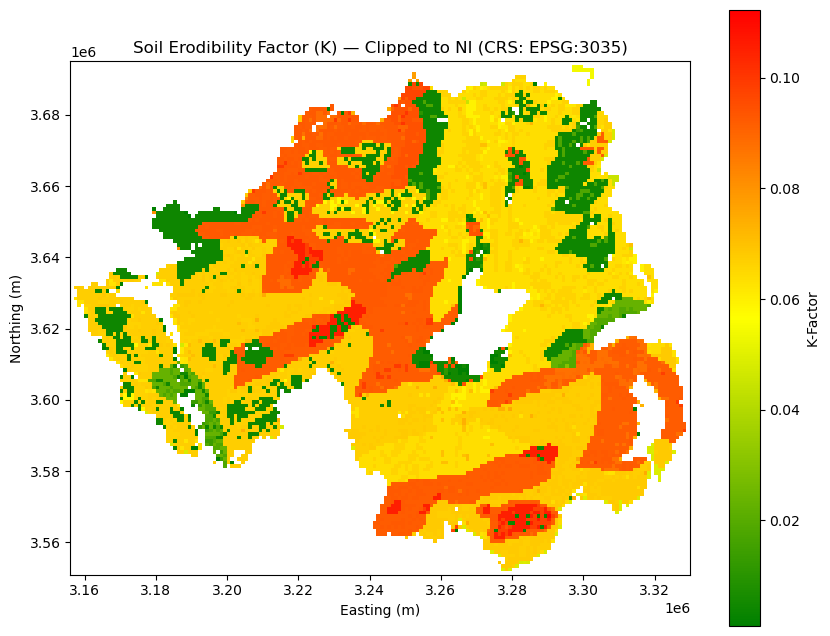

In [3]:
import rasterio
from rasterio.mask import mask
from rasterio.warp import reproject, Resampling
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import os
import pyproj
from matplotlib.colors import LinearSegmentedColormap

# ------------------------------------------------------------------------------
# 0. DEFINE TARGET CRS (should match SELECTED_CRS_KEY from your “choose CRS” cell)
# ------------------------------------------------------------------------------
# Example: replace with the desired key from your CRS_OPTIONS dictionary
TARGET_CRS = pyproj.CRS("EPSG:3035")  # e.g., EPSG:4326, EPSG:29903, EPSG:27700, EPSG:3035, etc.

# Helper to get the PROJ string or EPSG code for subprocess / to_crs calls
TARGET_CRS_STR = TARGET_CRS.to_string()  # e.g. "EPSG:3035"
TARGET_EPSG = TARGET_CRS.to_epsg()       # e.g. 3035

# ------------------------------------------------------------------------------
# 1. Convert .rst to .tif with TARGET_CRS
# ------------------------------------------------------------------------------

input_files = [
    r"C:/GIS_Course/EGM721/Github conversion of RUSLE/RUSLE-in-Python/Data/K/STU_EU_T_SILT.rst",
    r"C:/GIS_Course/EGM721/Github conversion of RUSLE/RUSLE-in-Python/Data/K/STU_EU_T_SAND.rst",
    r"C:/GIS_Course/EGM721/Github conversion of RUSLE/RUSLE-in-Python/Data/K/STU_EU_T_CLAY.rst",
    r"C:/GIS_Course/EGM721/Github conversion of RUSLE/RUSLE-in-Python/Data/K/STU_EU_S_OC.rst"
]
for rst_path in input_files:
    tif_path = rst_path.replace(".rst", ".tif")
    subprocess.run([
        "gdal_translate",
        "-a_srs", TARGET_CRS_STR, 
        "-of", "GTiff",
        rst_path,
        tif_path
    ], check=True)
   

# ------------------------------------------------------------------------------
# 2. Define file paths for the clipped data
# ------------------------------------------------------------------------------

silt_path    = r"C:\GIS_Course\EGM721\Github conversion of RUSLE\RUSLE-in-Python\Data\K\STU_EU_T_SILT.tif"
sand_path    = r"C:\GIS_Course\EGM721\Github conversion of RUSLE\RUSLE-in-Python\Data\K\STU_EU_T_SAND.tif"
clay_path    = r"C:\GIS_Course\EGM721\Github conversion of RUSLE\RUSLE-in-Python\Data\K\STU_EU_T_CLAY.tif"
oc_path      = r"C:\GIS_Course\EGM721\Github conversion of RUSLE\RUSLE-in-Python\Data\K\STU_EU_S_OC.tif"
texture_path = r"C:\GIS_Course\EGM721\Github conversion of RUSLE\RUSLE-in-Python\Data\K\textureUSDA_eu23.tif"
mask_path    = r"C:\GIS_Course\EGM721\Github conversion of RUSLE\RUSLE-in-Python\Data\NI_Outline.geojson"

# ------------------------------------------------------------------------------
# 3. Load Northern Ireland outline and reproject to TARGET_CRS
# ------------------------------------------------------------------------------

ni_outline = gpd.read_file(mask_path).to_crs(TARGET_CRS)

# ------------------------------------------------------------------------------
# 4. Helper to read + mask → returns (clipped_array, updated_profile)
# ------------------------------------------------------------------------------

def read_and_mask(path):
    with rasterio.open(path) as src:
        arr, out_transform = mask(src, ni_outline.geometry, crop=True)
        profile = src.profile.copy()
        profile.update({
            "height": arr.shape[1],
            "width": arr.shape[2],
            "transform": out_transform,
            "crs": TARGET_CRS_STR
        })
        return arr[0], profile

# ------------------------------------------------------------------------------
# 5. Clip each raster to Northern Ireland
# ------------------------------------------------------------------------------

silt, profile_silt       = read_and_mask(silt_path)
sand, _                  = read_and_mask(sand_path)
clay, _                  = read_and_mask(clay_path)
oc, _                    = read_and_mask(oc_path)
texture_clipped, profile_tex = read_and_mask(texture_path)

# ------------------------------------------------------------------------------
# 6. Reproject the clipped texture to exactly match the silt grid (TARGET_CRS)
# ------------------------------------------------------------------------------

texture_aligned = np.empty_like(silt, dtype=texture_clipped.dtype)
reproject(
    source=texture_clipped,
    destination=texture_aligned,
    src_transform=profile_tex["transform"],
    src_crs=profile_tex["crs"],
    dst_transform=profile_silt["transform"],
    dst_crs=profile_silt["crs"],
    resampling=Resampling.nearest
)

# ------------------------------------------------------------------------------
# 7. USDA lookups (soil structure & permeability)
# ------------------------------------------------------------------------------

structure_lookup = {
    1: 4, 2: 4, 3: 3, 4: 4, 5: 3, 6: 3, 
    7: 1, 8: 2, 9: 3, 10: 1, 11: 2, 12: 2
}

permeability_lookup = {
    1: 6, 2: 6, 3: 5, 4: 5, 5: 4, 6: 4,
    7: 3, 8: 3, 9: 2, 10: 1, 11: 1, 12: 2
}

structure_raster     = np.vectorize(lambda x: structure_lookup.get(x, 0))(texture_aligned)
permeability_raster  = np.vectorize(lambda x: permeability_lookup.get(x, 0))(texture_aligned)

# ------------------------------------------------------------------------------
# 8. Save structure and permeability rasters (they now match silt/clay/sand extent in TARGET_CRS)
# ------------------------------------------------------------------------------

profile_uint8 = profile_silt.copy()
profile_uint8.update(dtype=rasterio.uint8)

structure_out    = r"C:\GIS_Course\EGM721\Github conversion of RUSLE\RUSLE-in-Python\Data\K\structure.tif"
permeability_out = r"C:\GIS_Course\EGM721\Github conversion of RUSLE\RUSLE-in-Python\Data\K\permeability.tif"

with rasterio.open(structure_out, "w", **profile_uint8) as dst:
    dst.write(structure_raster.astype(np.uint8), 1)

with rasterio.open(permeability_out, "w", **profile_uint8) as dst:
    dst.write(permeability_raster.astype(np.uint8), 1)

# ------------------------------------------------------------------------------
# 9. Compute Soil Organic Matter (cap to 11%) and M–factor
# ------------------------------------------------------------------------------

SOM = np.clip(oc * 1.724, None, 11)
M   = (silt + sand) * (100 - clay)

# ------------------------------------------------------------------------------
# 10. Calculate K–factor with your exact formula (in TARGET_CRS)
# ------------------------------------------------------------------------------

k_factor = (
    (2.1e-4) * (M ** 1.14) * (12 - SOM)
    + 3.25 * (structure_raster - 2)
    + 2.5 * (permeability_raster - 3)
) / 100 / 7.59

# ------------------------------------------------------------------------------
# 11. Save K–factor (clipped to NI, in TARGET_CRS)
# ------------------------------------------------------------------------------

profile_float32 = profile_silt.copy()
profile_float32.update(dtype=rasterio.float32)

k_factor_out = r"C:\GIS_Course\EGM721\Github conversion of RUSLE\RUSLE-in-Python\Data\K\k_factor.tif"
with rasterio.open(k_factor_out, "w", **profile_float32) as dst:
    dst.write(k_factor.astype(np.float32), 1)

# ------------------------------------------------------------------------------
# 12. Display K–factor in TARGET_CRS
# ------------------------------------------------------------------------------

# 1. Define a green→yellow→red colormap
cmap = LinearSegmentedColormap.from_list("Gyr", ["green", "yellow", "red"])
# 2. Any value less than the minimum nonzero K should be fully transparent
cmap.set_under((0, 0, 0, 0))

# 3. Compute the smallest K > 0
min_nonzero = np.min(k_factor[k_factor > 0])

plt.figure(figsize=(10, 8))
plt.imshow(
    k_factor,
    cmap=cmap,
    vmin=min_nonzero,  # zeros become “under” (transparent)
    extent=[
        profile_silt["transform"][2],
        profile_silt["transform"][2] + profile_silt["transform"][0] * silt.shape[1],
        profile_silt["transform"][5] + profile_silt["transform"][4] * silt.shape[0],
        profile_silt["transform"][5]
    ]
)
plt.colorbar(label="K‐Factor")
plt.title(f"Soil Erodibility Factor (K) — Clipped to NI (CRS: EPSG:{TARGET_EPSG})")
plt.grid(False)

if TARGET_EPSG == 4326:
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
else:
    plt.xlabel("Easting (m)")
    plt.ylabel("Northing (m)")

plt.show()


## LS-Factor

The following code box calculates LS 

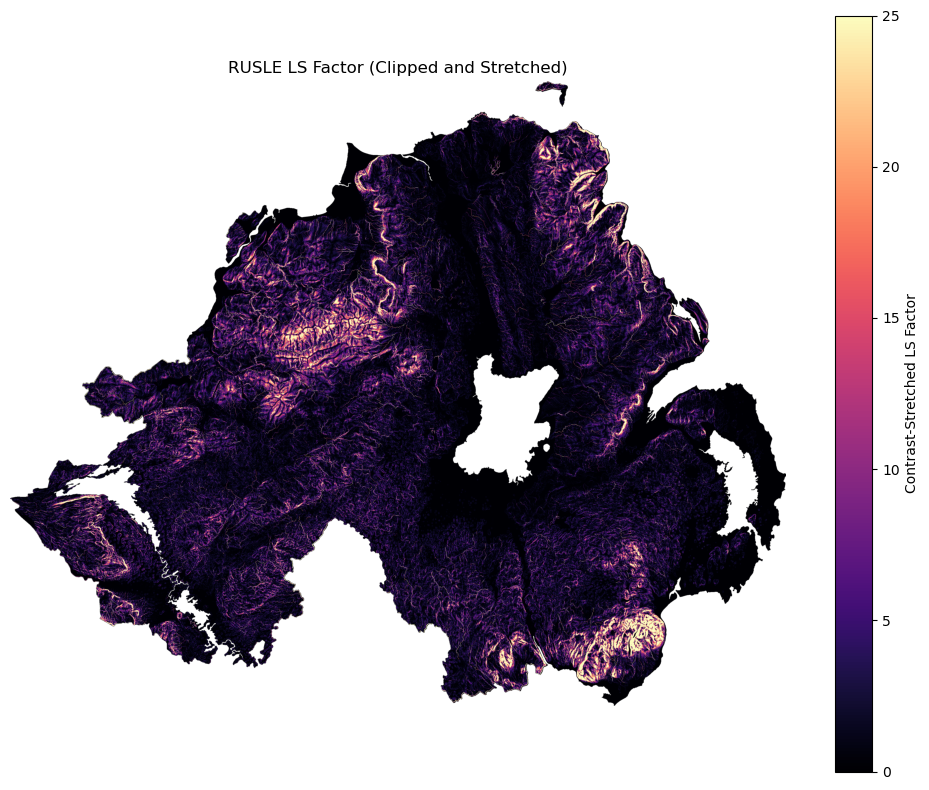

In [74]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import richdem as rd
from rasterio.mask import mask
from rasterio.io import MemoryFile

# File paths
input_dem_path = r"C:\GIS_Course\EGM721\Github conversion of RUSLE\RUSLE-in-Python\Data\LS\ni_dtm_metre.tif"
filled_dem_path = r"C:\GIS_Course\EGM721\Github conversion of RUSLE\RUSLE-in-Python\Data\LS\ni_dtm_filled.tif"
slope_output_path = r"C:\GIS_Course\EGM721\Github conversion of RUSLE\RUSLE-in-Python\Data\LS\slope_ang.tif"
flow_acc_path = r"C:\GIS_Course\EGM721\Github conversion of RUSLE\RUSLE-in-Python\Data\LS\flow_acc.tif"
ni_outline_path = r"C:\GIS_Course\EGM721\Github conversion of RUSLE\RUSLE-in-Python\Data\NI_Outline.geojson"
output_ls_path = r"C:\GIS_Course\EGM721\Github conversion of RUSLE\RUSLE-in-Python\Data\LS\LS.tif"

# === Step 1: Load DEM and fill depressions ===
with rasterio.open(input_dem_path) as src:
    dem = src.read(1, masked=True)
    profile = src.profile
    cell_size = src.res[0]

rdem = rd.rdarray(dem.filled(np.nan), no_data=np.nan)
rdem.geotransform = [profile['transform'][2], cell_size, 0, profile['transform'][5], 0, -cell_size]

rdem_filled = rd.FillDepressions(rdem, in_place=False)

profile.update(dtype=rasterio.float32, nodata=np.nan)
with rasterio.open(filled_dem_path, 'w', **profile) as dst:
    dst.write(rdem_filled.astype(rasterio.float32), 1)

# === Step 2: Calculate slope in degrees ===
slope = rd.TerrainAttribute(rdem_filled, attrib='slope_degrees')

with rasterio.open(slope_output_path, 'w', **profile) as dst:
    dst.write(slope.astype(rasterio.float32), 1)

# === Step 3: Calculate flow accumulation ===
flow_acc = rd.FlowAccumulation(rdem_filled, method='D8')

with rasterio.open(flow_acc_path, 'w', **profile) as dst:
    dst.write(flow_acc.astype(rasterio.float32), 1)

# === Step 4: Compute LS factor and clip ===
slope_percent = np.tan(np.radians(slope)) * 100
LS = ((flow_acc * cell_size / 22.1) ** 0.5) * (0.065 + 0.045 * slope_percent + 0.0065 * (slope_percent ** 2))

ni_outline = gpd.read_file(ni_outline_path)
ni_outline = ni_outline.to_crs(profile['crs'])

with MemoryFile() as memfile:
    with memfile.open(**profile) as tmp:
        tmp.write(LS.astype(rasterio.float32), 1)
        LS_clipped, transform = mask(dataset=tmp, shapes=ni_outline.geometry, crop=True, filled=True, nodata=np.nan)

clipped_profile = profile.copy()
clipped_profile.update({
    "height": LS_clipped.shape[1],
    "width": LS_clipped.shape[2],
    "transform": transform
})

with rasterio.open(output_ls_path, 'w', **clipped_profile) as dst:
    dst.write(LS_clipped.astype(rasterio.float32))

plt.figure(figsize=(10, 8))
plt.imshow(LS_clipped[0], cmap='magma', vmin=0, vmax=25)
plt.colorbar(label='Contrast-Stretched LS Factor')
plt.title('RUSLE LS Factor (Clipped and Stretched)')
plt.axis('off')
plt.tight_layout()
plt.show()
